In [1]:
import os
from os import listdir
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import cv2
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import time
import glob
import random
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3, ResNet50
from tensorflow.keras.layers import Flatten, Dense, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from tensorflow.keras.layers import Add, Conv2D, BatchNormalization, LeakyReLU, PReLU, Conv2DTranspose

2024-11-20 14:55:01.737647: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-20 14:55:01.749573: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732082101.764644    9015 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732082101.768797    9015 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 14:55:01.784525: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Set random seed for reproducibility
random.seed(100)

# Load image paths
DATA_DIR = os.path.join("/home/user/Desktop", "CNN_Breast_Cancer", "Histopathology", "IDC_regular_ps50_idx5", "**", "*.png")
breast_imgs = glob.glob(DATA_DIR, recursive=True)


In [3]:
for imgname in breast_imgs[:5]:
    print(imgname)

/home/user/Desktop/CNN_Breast_Cancer/Histopathology/IDC_regular_ps50_idx5/9175/0/9175_idx5_x3701_y501_class0.png
/home/user/Desktop/CNN_Breast_Cancer/Histopathology/IDC_regular_ps50_idx5/9175/0/9175_idx5_x3901_y851_class0.png
/home/user/Desktop/CNN_Breast_Cancer/Histopathology/IDC_regular_ps50_idx5/9175/0/9175_idx5_x201_y301_class0.png
/home/user/Desktop/CNN_Breast_Cancer/Histopathology/IDC_regular_ps50_idx5/9175/0/9175_idx5_x1901_y151_class0.png
/home/user/Desktop/CNN_Breast_Cancer/Histopathology/IDC_regular_ps50_idx5/9175/0/9175_idx5_x1951_y501_class0.png


In [4]:
non_cancer_imgs = [img for img in breast_imgs if img[-5] == '0']
cancer_imgs = [img for img in breast_imgs if img[-5] == '1']

non_cancer_num = len(non_cancer_imgs)  # No cancer
cancer_num = len(cancer_imgs)   # Cancer 
        
total_img_num = non_cancer_num + cancer_num
        
print('Number of Images of no cancer: {}' .format(non_cancer_num))   # images of Non cancer
print('Number of Images of cancer : {}' .format(cancer_num))   # images of cancer 
print('Total Number of Images : {}' .format(total_img_num))

Number of Images of no cancer: 198738
Number of Images of cancer : 78786
Total Number of Images : 277524


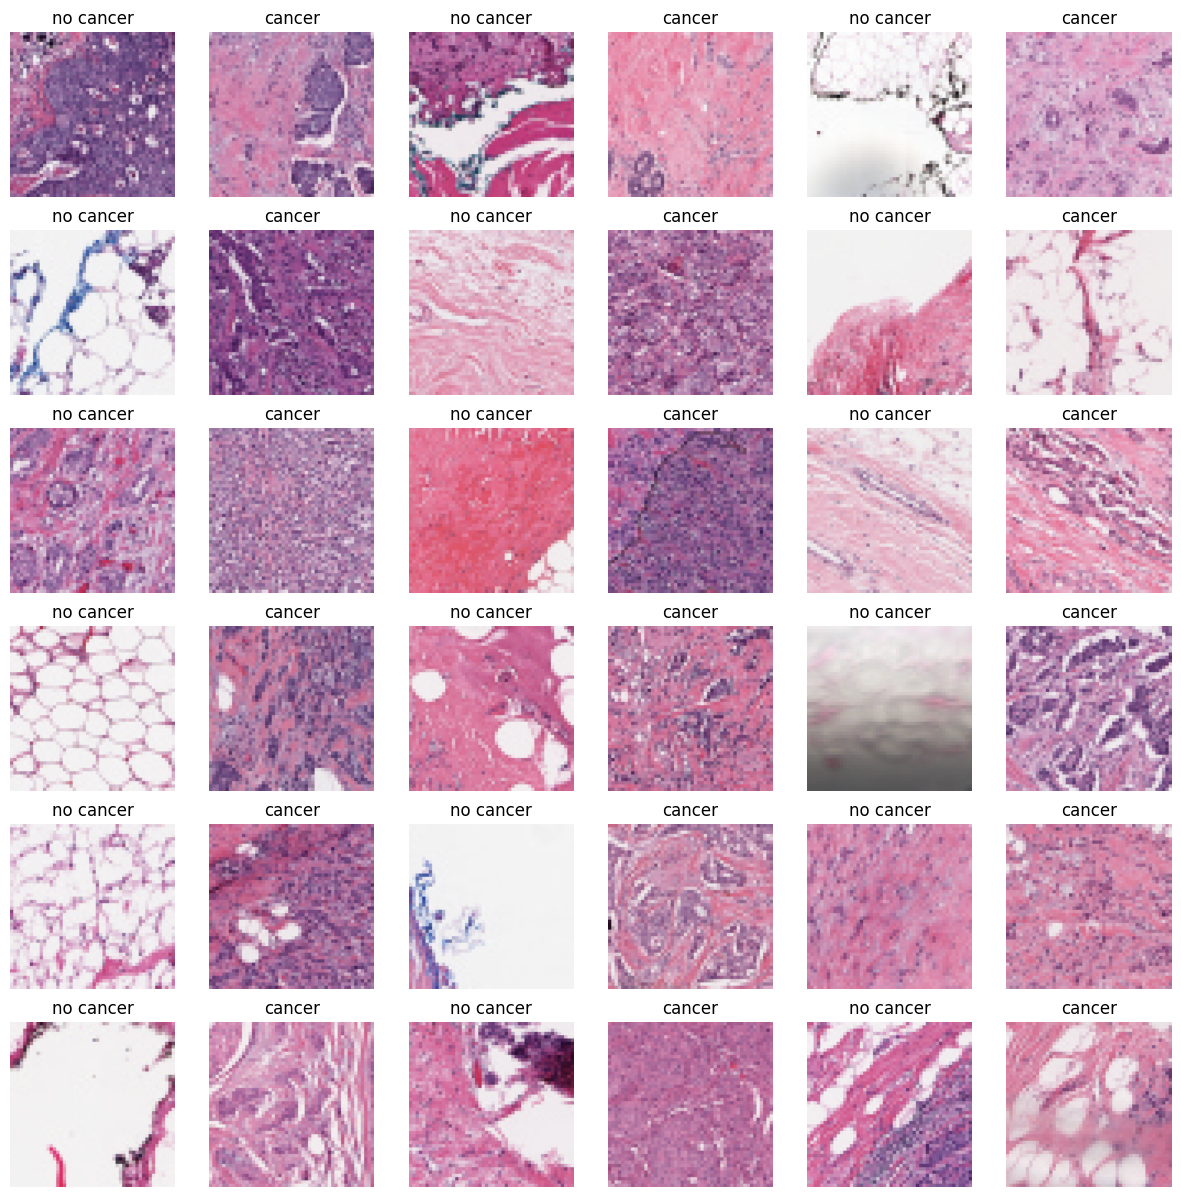

In [5]:
# Separate cancer and non-cancer images
non_cancer_imgs = []
cancer_imgs = []

for img in breast_imgs:
    if img[-5] == '0':
        non_cancer_imgs.append(img)
    elif img[-5] == '1':
        cancer_imgs.append(img)

# Sampling some images for visualization
some_non = np.random.randint(0, len(non_cancer_imgs), 18)
some_can = np.random.randint(0, len(cancer_imgs), 18)

# Loading and preparing images for visualization
plt.figure(figsize=(15, 15))
s = 0
for num in some_non:
    img = image.load_img(non_cancer_imgs[num], target_size=(100, 100))
    img = image.img_to_array(img)
    plt.subplot(6, 6, 2 * s + 1)
    plt.axis('off')
    plt.title('no cancer')
    plt.imshow(img.astype('uint8'))
    s += 1

s = 1
for num in some_can:
    img = image.load_img(cancer_imgs[num], target_size=(100, 100))
    img = image.img_to_array(img)
    plt.subplot(6, 6, 2 * s)
    plt.axis('off')
    plt.title('cancer')
    plt.imshow(img.astype('uint8'))
    s += 1



In [6]:
# Load and preprocess images
non_img_arr = []
can_img_arr = []

for img in non_cancer_imgs:
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(n_img, (50, 50), interpolation=cv2.INTER_LINEAR)
    non_img_arr.append([n_img_size, 0])

for img in cancer_imgs:
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    c_img_size = cv2.resize(c_img, (50, 50), interpolation=cv2.INTER_LINEAR)
    can_img_arr.append([c_img_size, 1])

# Combine non-cancer and cancer data
breast_img_arr = non_img_arr + can_img_arr
random.shuffle(breast_img_arr)


In [7]:
# Prepare X and y
X = []
y = []

for feature, label in breast_img_arr:
    X.append(feature)
    y.append(label)

X = np.array(X)
y = np.array(y)
# Print the shape of the 'X' array
print('X shape: {}'.format(X.shape))


X shape: (277524, 50, 50, 3)


In [8]:

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# One-hot encode labels
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)
y_val = to_categorical(y_val, 2)


print('X_train shape : {}' .format(X_train.shape))
print('X_test shape : {}' .format(X_test.shape))
print('X_val shape : {}' .format(X_val.shape))
print('y_train shape : {}' .format(y_train.shape))
print('y_test shape : {}' .format(y_test.shape))
print('y_val shape : {}' .format(y_val.shape))

X_train shape : (222019, 50, 50, 3)
X_test shape : (27753, 50, 50, 3)
X_val shape : (27752, 50, 50, 3)
y_train shape : (222019, 2)
y_test shape : (27753, 2)
y_val shape : (27752, 2)


In [9]:
# Data augmentation
datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_datagen = datagen.flow(X_train, y_train, batch_size=16)
val_datagen = datagen.flow(X_val, y_val, batch_size=16)
test_datagen = datagen.flow(X_test, y_test, batch_size=16, shuffle=False)


In [10]:
# from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, concatenate
# from tensorflow.keras.applications import InceptionV3, ResNet50
# from tensorflow.keras.mixed_precision import set_global_policy

# # Enable mixed precision
# set_global_policy('mixed_float16')  # Enable mixed precision globally

# # Input tensor
# input_tensor = Input(shape=(64, 64, 3))

# # InceptionV3 for feature extraction
# inception_base = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_tensor)
# x1 = GlobalAveragePooling2D()(inception_base.output)

# # ResNet50 for feature extraction
# resnet_base = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
# x2 = GlobalAveragePooling2D()(resnet_base.output)

# # Concatenate features
# combined_features = concatenate([x1, x2])
# x = Dense(128, activation='relu')(combined_features)
# x = Dropout(0.5)(x)

# # Output layer
# output = Dense(2, activation='softmax')(x)

# # Final model
# model = tf.keras.Model(inputs=input_tensor, outputs=output)

# model.summary()


In [11]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.models import Model

# Define input shape
input_tensor = Input(shape=(50, 50, 3))
# Load EfficientNetB0 as a feature extractor
efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Add classification layers
x = Flatten()(efficientnet_base.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(2, activation='softmax')(x)

# Create the model
model = Model(inputs=efficientnet_base.input, outputs=output)

print(model.summary())


I0000 00:00:1732082128.171651    9015 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 976 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:4e:00.0, compute capability: 8.6
I0000 00:00:1732082128.172008    9015 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22189 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:85:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50, 50, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 50, 50, 3) │          0 │ input_layer[0][0] │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 50, 50, 3) │          7 │ rescaling[0][0]   │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 50, 50, 3) │          0 │ normalization[0]… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 51, 51, 3) │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 25, 25,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 25, 25,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 25, 25,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 25, 25,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 25, 25,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 25, 25,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 25, 25,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 25, 25,    │        512 │ block1a_se_excit

 Total params: 4,705,317 (17.95 MB)

 Trainable params: 4,663,294 (17.79 MB)

 Non-trainable params: 42,023 (164.16 KB)

None


In [12]:

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks for model saving and learning rate adjustment
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('Breast_Cancer_Detection_IncepResNet.keras', monitor='val_loss', verbose=1, save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

# Train the model and calculate training time
start_time = time.time()

history = model.fit(
    train_datagen,
    epochs=50,
    validation_data=val_datagen,
    callbacks=callbacks
)

end_time = time.time()
training_time = end_time - start_time
training_time_str = time.strftime('%H:%M:%S', time.gmtime(training_time))
print(f'Training Time: {training_time_str}')


Epoch 1/50


/home/user/anaconda3/envs/GPU/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/home/user/anaconda3/envs/GPU/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(
I0000 00:00:1732082143.362320    9113 service.cc:148] XLA service 0x7faf68015370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732082143.362354    9113 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
I0000 00:00:1732082143.362358    9113 service.cc:156]   StreamExec

   11/13877 ━━━━━━━━━━━━━━━━━━━━ 2:38 11ms/step - accuracy: 0.4966 - loss: 0.9375   

I0000 00:00:1732082164.512711    9113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13875/13877 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8258 - loss: 0.4089
Epoch 1: val_loss improved from inf to 1.20210, saving model to Breast_Cancer_Detection_IncepResNet.keras
13877/13877 ━━━━━━━━━━━━━━━━━━━━ 219s 13ms/step - accuracy: 0.8258 - loss: 0.4089 - val_accuracy: 0.7104 - val_loss: 1.2021 - learning_rate: 1.0000e-04
Epoch 2/50
13875/13877 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8669 - loss: 0.3201
Epoch 2: val_loss improved from 1.20210 to 1.02531, saving model to Breast_Cancer_Detection_IncepResNet.keras
13877/13877 ━━━━━━━━━━━━━━━━━━━━ 163s 12ms/step - accuracy: 0.8669 - loss: 0.3201 - val_accuracy: 0.7159 - val_loss: 1.0253 - learning_rate: 1.0000e-04
Epoch 3/50
13877/13877 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8769 - loss: 0.2969
Epoch 3: val_loss did not improve from 1.02531
13877/13877 ━━━━━━━━━━━━━━━━━━━━ 163s 12ms/step - accuracy: 0.8769 - loss: 0.2969 - val_accuracy: 0.7157 - val_loss: 2.5029 - learning_rate: 1.0000e-04
Epoch 4/50
13875/13

In [15]:
#use the train and val set in the model.fit()
model.evaluate(test_datagen) # use the test set here

1735/1735 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.9067 - loss: 0.2397


[0.24356162548065186, 0.9057399034500122]

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Assuming Y_pred and Y_true are already defined
# Y_pred is the output from model.predict, Y_pred_classes is obtained by np.argmax(Y_pred, axis=1)
y_pred = model.predict(test_datagen)
Y_true = np.argmax(y_test, axis=1)  # Make sure y_test is correctly prepared
y_pred_classes = np.argmax(y_pred, axis=1)
# Calculate Precision, Recall, and F1 Score
precision = precision_score(Y_true, y_pred_classes)
recall = recall_score(Y_true, y_pred_classes)
f1 = f1_score(Y_true, y_pred_classes)

# Calculate the probabilities for the positive class
Y_pred_probs = y_pred[:, 1]  # assuming your model outputs probabilities for each class

# ROC AUC Score
roc_auc = roc_auc_score(Y_true, Y_pred_probs)

# Print the metrics
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")

1735/1735 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step
Precision: 0.84
Recall: 0.83
F1 Score: 0.83
ROC AUC Score: 0.96


Text(0.5, 1.0, 'Accuracy vs Epochs')

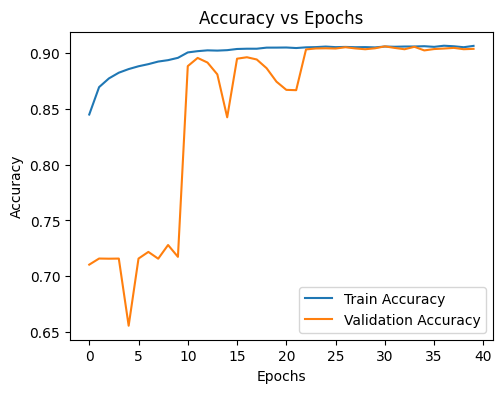

In [22]:
# Plot accuracy vs epochs and loss vs epochs
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')


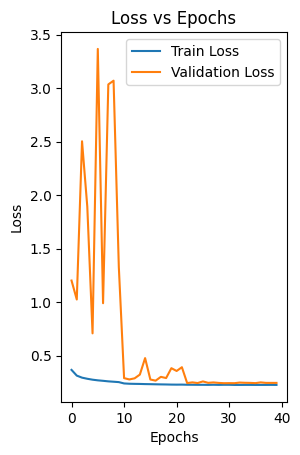

In [23]:

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')

plt.show()

1735/1735 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step


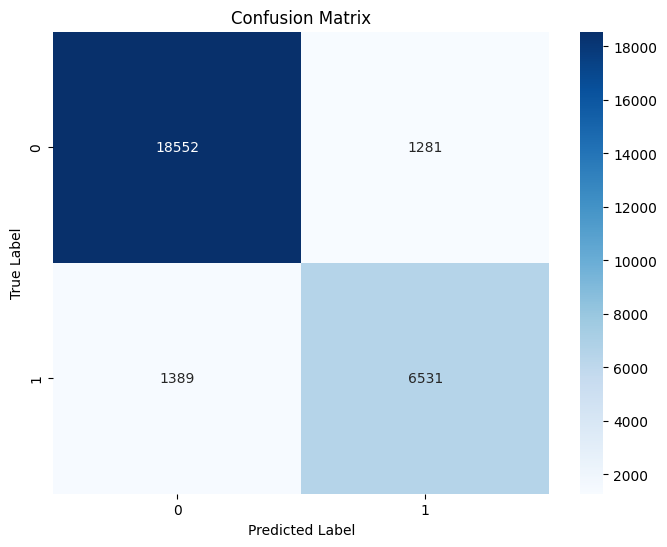

In [24]:
# Confusion matrix
y_pred = model.predict(test_datagen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [32]:
import torch

# Set the device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


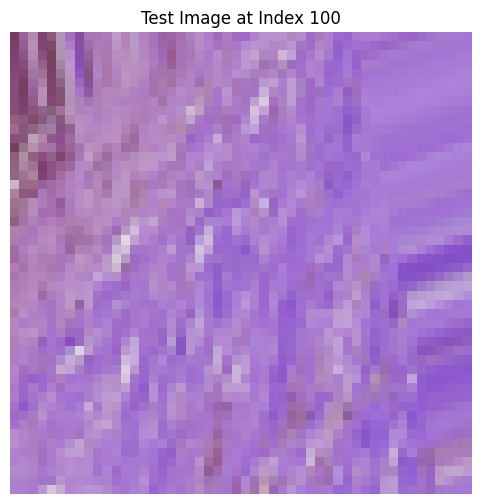

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted Diagnosis: Non-Cancerous
Calcification Type: No Calcification
True Diagnosis: Non-Cancerous


In [39]:
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt

# Define mappings for class labels and calcification types
class_labels = {
    0: 'Non-Cancerous',
    1: 'Cancerous',
}

calcification_types = {
    0: 'No Calcification',
    1: 'PLEOMORPHIC',
    2: 'AMORPHOUS',
    3: 'PUNCTATE',
    4: 'LUCENT_CENTER',
    5: 'VASCULAR',
    6: 'FINE_LINEAR_BRANCHING',
    7: 'COARSE',
    8: 'ROUND_AND_REGULAR-LUCENT_CENTER',
    9: 'PLEOMORPHIC-FINE_LINEAR_BRANCHING',
    10: 'ROUND_AND_REGULAR-LUCENT_CENTER-PUNCTATE',
    11: 'ROUND_AND_REGULAR-EGGSHELL',
    12: 'PUNCTATE-PLEOMORPHIC',
    13: 'DYSTROPHIC',
    14: 'LUCENT_CENTERED',
    15: 'ROUND_AND_REGULAR-LUCENT_CENTER-DYSTROPHIC',
    16: 'ROUND_AND_REGULAR',
    17: 'ROUND_AND_REGULAR-LUCENT_CENTERED',
    18: 'AMORPHOUS-PLEOMORPHIC',
    19: 'LARGE_RODLIKE-ROUND_AND_REGULAR',
    20: 'PUNCTATE-AMORPHOUS',
    21: 'COARSE-ROUND_AND_REGULAR-LUCENT_CENTER',
    22: 'VASCULAR-COARSE-LUCENT_CENTERED',
    23: 'LUCENT_CENTER-PUNCTATE',
    24: 'ROUND_AND_REGULAR-PLEOMORPHIC',
    25: 'EGGSHELL',
    26: 'PUNCTATE-FINE_LINEAR_BRANCHING',
    27: 'VASCULAR-COARSE',
    28: 'ROUND_AND_REGULAR-PUNCTATE',
    29: 'SKIN-PUNCTATE-ROUND_AND_REGULAR',
    30: 'SKIN-PUNCTATE',
    31: 'COARSE-ROUND_AND_REGULAR-LUCENT_CENTERED',
    32: 'PUNCTATE-ROUND_AND_REGULAR',
    33: 'LARGE_RODLIKE',
    34: 'AMORPHOUS-ROUND_AND_REGULAR',
    35: 'PUNCTATE-LUCENT_CENTER',
    36: 'SKIN',
    37: 'VASCULAR-COARSE-LUCENT_CENTER-ROUND_AND_REGULA',
    38: 'COARSE-PLEOMORPHIC',
    39: 'ROUND_AND_REGULAR-PUNCTATE-AMORPHOUS',
    40: 'COARSE-LUCENT_CENTER',
    41: 'MILK_OF_CALCIUM',
    42: 'COARSE-ROUND_AND_REGULAR',
    43: 'SKIN-COARSE-ROUND_AND_REGULAR',
    44: 'ROUND_AND_REGULAR-AMORPHOUS',
    45: 'PLEOMORPHIC-PLEOMORPHIC'
}
def img_plot(data_gen, index=0):
    """
    Display an image from the dataset.
    """
    if index >= len(data_gen):
        print("Index is out of bounds.")
        return

    # Extract the image
    if isinstance(data_gen[index], tuple):
        img_data = data_gen[index][0]
    else:
        img_data = data_gen[index]

    if len(img_data.shape) == 4:  # If batch dimension exists, take the first image
        img_data = img_data[0]

    # Ensure the data is in uint8 format for display
    img_data = np.array(img_data)
    if img_data.max() <= 1.0:  # Assume normalized data, scale back to [0, 255]
        img_data = (img_data * 255).astype(np.uint8)

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(img_data)
    plt.title(f"Test Image at Index {index}")
    plt.axis('off')
    plt.show()

# Specify index
index = 100

# Plot the image
img_plot(test_datagen, index)

# Extract a single image
if isinstance(test_datagen[index], tuple):
    input_image = test_datagen[index][0][0]
else:
    input_image = test_datagen[index]

# Preprocess the image
input_image = Image.fromarray(np.uint8(input_image)).resize((50, 50))
input_image_tensor = np.expand_dims(np.array(input_image), axis=0).astype("float32") / 255.0

# Pass the image through the Keras model
predicted_results = model.predict(input_image_tensor)
predicted_class_index = np.argmax(predicted_results, axis=1)[0]
# Get the true label from the y_test array
true_class_index = y_test[index].argmax()
true_label = class_labels[true_class_index]
# Interpret predictions
predicted_label = class_labels.get(predicted_class_index, "Unknown")
calcification_type = calcification_types.get(predicted_class_index, "Unknown")

print('Predicted Diagnosis:', predicted_label)
print('Calcification Type:', calcification_type)
print('True Diagnosis:', true_label)

In [42]:
# import papermill as pm

# # Path to the input notebook
# input_notebook = "/home/user/Desktop/CNN_Breast_Cancer/CLAHE_Preprocessing_ProvGiga_Path.ipynb"

# # Path to save the executed notebook
# output_notebook = "/home/user/Desktop/CNN_Breast_Cancer/Executed_CLAHE_Preprocessing_ProvGiga_Path.ipynb"

# # Execute the notebook
# pm.execute_notebook(
#     input_notebook,  # Path to the input notebook
#     output_notebook  # Path where the executed notebook will be saved
# )

# print(f"Executed notebook saved at: {output_notebook}")
